Notebook correspondant à la section 3.2 du rapport, pour la résolution des équations couplées de la précession de Larmor :
\begin{equation}
\left\{
    \begin{aligned}
        \frac{dM_x}{dt} &= \omega M_y \\
        \frac{dM_y}{dt} &= -\omega M_x
    \end{aligned}
\right.
\end{equation}

In [2]:
#imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Physical parameters

In [3]:
M_0 = tf.constant([1,0], dtype='float32')
W = 2*np.pi
#matrix defining the differential equation
P = W*np.array([[0,1], [-1, 0]], dtype = 'float32')

2022-07-26 11:29:14.816951: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Training parameters

In [29]:
N = 40 #number of samples for the independant variable
training_points = np.linspace(-1,1,N)
training_points = tf.convert_to_tensor(training_points, dtype=tf.float32)

load_model = False
load_filename = "models/2_NN_direct_training_N=10"
save_model = False
save_filename = "models/2_NN_direct_training_N=100"
learning_rate = 1
epochs = 1000
display_step = min(max(1,epochs//100), 1000)

Initializing the network

In [5]:
# Network Parameters
n_input = 1     # input layer number of neurons
n_hidden_1 = 32 # 1st layer number of neurons
n_hidden_2 = 8  # 2nd layer number of neurons
n_output = 2    # output layer number of neurons

#model definition :
model = tf.keras.Sequential([
  tf.keras.layers.Dense(n_hidden_1, activation=tf.nn.sigmoid, input_shape=(n_input,)),  # input shape required
  tf.keras.layers.Dense(n_hidden_2, activation=tf.nn.sigmoid),
  tf.keras.layers.Dense(n_output)
])

if load_model :
    model = tf.keras.models.load_model(load_filename)

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

Loss function
https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/GradientTape


In [21]:
def loss_function(model, input_tensor, M_0):

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(input_tensor)
        output = model(input_tensor)
        Mx, My = M_0[0]+input_tensor*output[:,0], M_0[1]+input_tensor*output[:,1]

    dMx = tape.gradient(Mx, input_tensor)
    dMy = tape.gradient(My, input_tensor)

    ex = dMx - W*My
    ey = dMy + W*Mx

    return tf.reduce_mean(ex**2 + ey**2)

gradient of loss

In [22]:
def grad(model, input_tensor, M_0):
    with tf.GradientTape() as tape:
        loss_value = loss_function(model, input_tensor, M_0)

    gradient = tape.gradient(loss_value, model.trainable_variables)

    return loss_value, gradient

Training the neural network

In [31]:

losses = []
epochs_displayed = []

for epoch in range(epochs) :
    loss_value, grads = grad(model, training_points, M_0)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if epoch % display_step == 0 :
        print("Loss after",epoch,"/",epochs,"epochs :",loss_value.numpy())
        losses.append(loss_value.numpy())
        epochs_displayed.append(epoch)

loss_value, grads = grad(model, training_points, M_0)
print("Final loss after",epochs,"epochs :",loss_value.numpy())
losses.append(loss_value.numpy())
epochs_displayed.append(epochs)

Loss after 0 / 1000 epochs : 0.83947086
Loss after 10 / 1000 epochs : 0.83902866
Loss after 20 / 1000 epochs : 0.8385862
Loss after 30 / 1000 epochs : 0.8381441
Loss after 40 / 1000 epochs : 0.8377023
Loss after 50 / 1000 epochs : 0.83725965
Loss after 60 / 1000 epochs : 0.8368176
Loss after 70 / 1000 epochs : 0.83637655
Loss after 80 / 1000 epochs : 0.8359338
Loss after 90 / 1000 epochs : 0.8354925
Loss after 100 / 1000 epochs : 0.8350509
Loss after 110 / 1000 epochs : 0.8346096
Loss after 120 / 1000 epochs : 0.8341676
Loss after 130 / 1000 epochs : 0.8337264
Loss after 140 / 1000 epochs : 0.83328485
Loss after 150 / 1000 epochs : 0.83284366
Loss after 160 / 1000 epochs : 0.83240163
Loss after 170 / 1000 epochs : 0.83196163
Loss after 180 / 1000 epochs : 0.8315199
Loss after 190 / 1000 epochs : 0.8310795
Loss after 200 / 1000 epochs : 0.83063775
Loss after 210 / 1000 epochs : 0.8301978
Loss after 220 / 1000 epochs : 0.8297564
Loss after 230 / 1000 epochs : 0.8293158
Loss after 240 / 1

In [ ]:
if save_model :
    model.save(save_filename)

Plot the evolution of loss

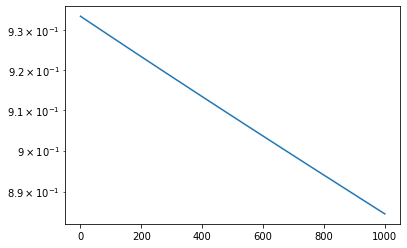

In [25]:
plt.plot(epochs_displayed, losses)
plt.yscale('log')
plt.show()


Plot the estimation and the analytic solution

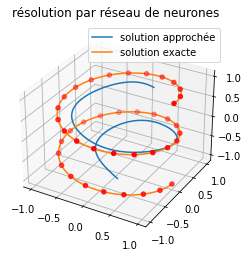

In [30]:
plotting_points = np.linspace(-1,1,200)
plotting_points = tf.convert_to_tensor(plotting_points, dtype=tf.float32)

#neural network estimation
output = model(plotting_points)
Mx_NN, My_NN = M_0[0]+plotting_points*output[:,0], M_0[1]+plotting_points*output[:,1]

#analytic solution
Mx_ana =  M_0[0]*np.cos(W*plotting_points) + M_0[1]*np.sin(W*plotting_points)
My_ana = -M_0[0]*np.sin(W*plotting_points) + M_0[1]*np.cos(W*plotting_points)

#training points
Mx_ana_training_points =  M_0[0]*np.cos(W*training_points) + M_0[1]*np.sin(W*training_points)
My_ana_training_points = -M_0[0]*np.sin(W*training_points) + M_0[1]*np.cos(W*training_points)


#3D plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(        xs=Mx_NN,
                ys=My_NN,
                zs=plotting_points,
                label='solution approchée')

ax.plot(        xs=Mx_ana,
                ys=My_ana,
                zs=plotting_points,
                label='solution exacte')



ax.scatter(     xs=Mx_ana_training_points,
                ys=My_ana_training_points,
                zs=training_points,
                color='red')

plt.legend()
plt.title('résolution par réseau de neurones')
plt.show()